In [1]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sampleSubmission.csv')
test_id = test['id']

In [3]:
print(train.shape)
train.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
print(test.shape)
test.head()

(58921, 10)


,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
sample.head()

,Id,Action
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Exploration

ACTION: ACTION is 1 if the resource was approved, 0 if the resource was not.

RESOURCE: An ID for each resource.

MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time.

ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering).

ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail).

ROLE_DEPTNAME: Company role department description (e.g. Retail).

ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager).

ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering).

ROLE_FAMILY: Company role family description (e.g. Retail Manager).

ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager).

In [6]:
print(train.shape)
print(train.isnull().sum())
train.info()

(32769, 10)
ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [7]:
print(test.shape)
print(test.isnull().sum())
test.info()

(58921, 10)
id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


## No null values, let's check outliers, skewness

<AxesSubplot:xlabel='ACTION', ylabel='Density'>

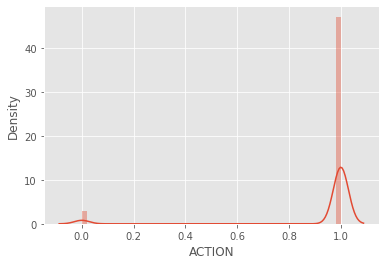

In [8]:
sns.distplot(train['ACTION'])

----------Box Plots for detecting outliers---------


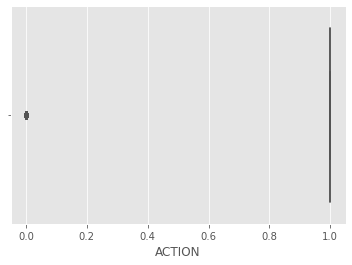

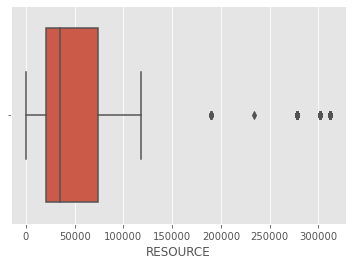

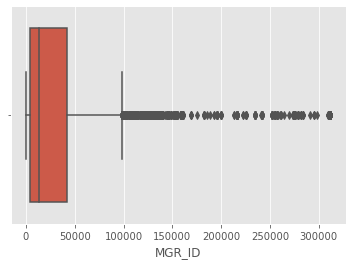

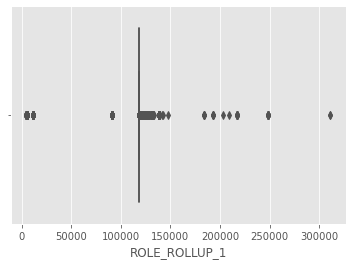

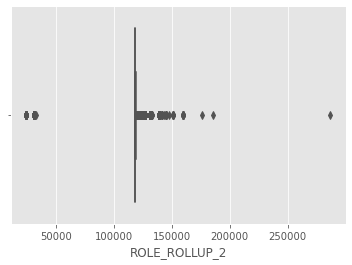

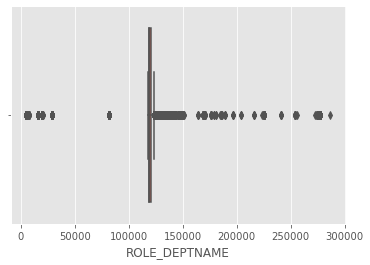

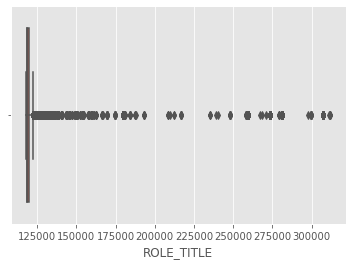

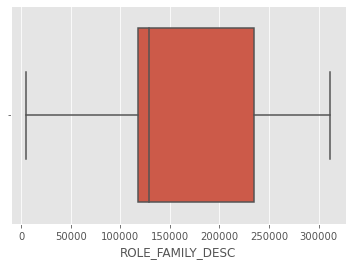

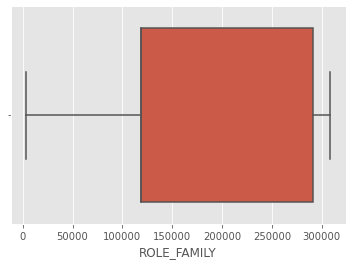

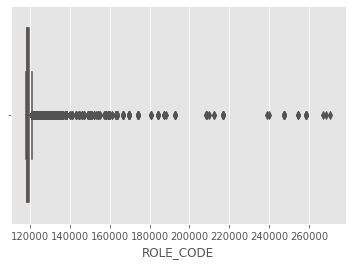

In [9]:
print("----------Box Plots for detecting outliers---------")
cols = train.columns
for i in cols:
    plt.figure()
    sns.boxplot(train[i])

#### Check the test set to make sure we don't delete important data

<AxesSubplot:xlabel='RESOURCE'>

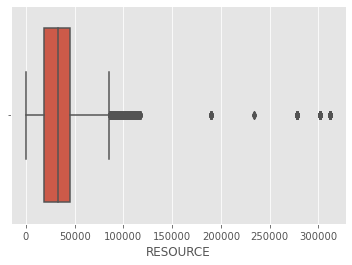

In [10]:
# Resource
sns.boxplot(test['RESOURCE'])

<AxesSubplot:xlabel='ROLE_ROLLUP_1'>

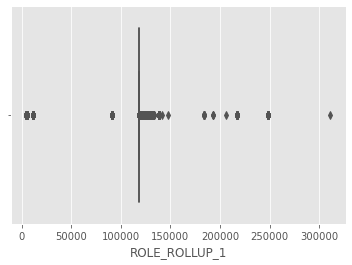

In [11]:
# Role Rollup 1
sns.boxplot(test['ROLE_ROLLUP_1'])

<AxesSubplot:xlabel='ROLE_ROLLUP_2'>

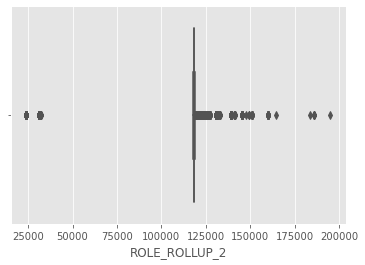

In [12]:
# Role Rollup 2
sns.boxplot(test['ROLE_ROLLUP_2'])

<AxesSubplot:xlabel='ROLE_DEPTNAME'>

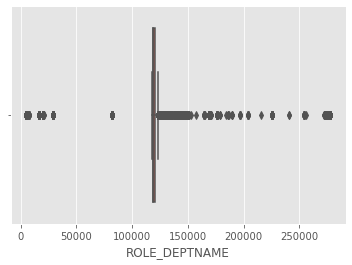

In [13]:
# Role Detpname
sns.boxplot(test['ROLE_DEPTNAME'])

<AxesSubplot:xlabel='ROLE_CODE'>

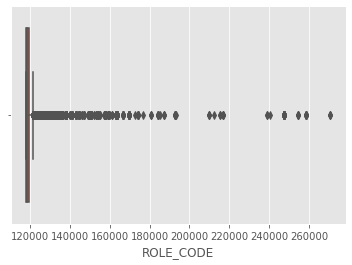

In [14]:
# Role Code
sns.boxplot(test['ROLE_CODE'])

- I guess it's gonna be better if we do nothing with ('resource', 'role rollup 1', 'role_detpname', 'role_code') columns
- We handle the rest of the outliers

In [15]:
# resource_outliers = train[train['RESOURCE'] > 150000]
# role_rollup_1_outliers1 = train[train['ROLE_ROLLUP_1'] > 150000]  
# role_rollup_1_outliers2 = train[train['ROLE_ROLLUP_1'] < 100000]
# role_rollup_1_outliers = pd.concat([role_rollup_1_outliers1, role_rollup_1_outliers2], axis=0)
role_rollup_2_outliers1 = train[train['ROLE_ROLLUP_2'] > 200000]
# role_rollup_2_outliers2 = train[train['ROLE_ROLLUP_2'] < 100000]
# role_rollup_2_outliers = pd.concat([role_rollup_2_outliers1, role_rollup_2_outliers2], axis=0)
# role_deptname_outliers = train[train['ROLE_DEPTNAME'] < 100000]
# role_code_outliers = train[train['ROLE_CODE'] > 200000]
# print("Rsource outliers:", len(resource_outliers))
# print("Role Rollup 1 outliers:", len(role_rollup_1_outliers))
print("Role Rollup 2 outliers:", len(role_rollup_2_outliers1))
# print("Role detname outliers:", len(role_deptname_outliers))
# print("Role code outliers:", len(role_code_outliers))

Role Rollup 2 outliers: 1


In [16]:
# print(train.shape)
# lst = [resource_outliers, role_rollup_1_outliers, role_rollup_2_outliers, role_deptname_outliers, role_code_outliers]
# for i in lst:
#     todrop = list(i.index)
#     try:
#         train.drop(todrop, axis=0, inplace=True)
#     except Exception as e:
#         print(len(i))
#         print(e)
#         continue
# print(train.shape)

In [18]:
print(train.shape)
todrop = list(role_rollup_2_outliers1.index)
train.drop(todrop, axis=0, inplace=True)
print(train.shape)

(32769, 10)
(32768, 10)
